In [1]:
%%html
<style>body{--vscode-font-family: "D2Coding"}</style>

In [2]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
from scipy.special import jv, kv, jvp, kvp, jn_zeros, jnp_zeros
from scipy.optimize import fsolve, minimize

# Solving Characteristic equations

## TE mode equation

$$
\frac{w\,J_1(u)}{J_0(u)} + \frac{u\,K_1(w)}{K_0} = 0
$$

## TM mode equation

$$
\left(\frac{n_1}{n_2}\right)^2\frac{w\,J_1(u)}{J_0(u)} + \frac{u\,K_1(w)}{K_0} = 0
$$

## Hybrid mode equation

$$
\left[
	\frac{J_q'(u)}{u\,J_q(u)} + \frac{K_q'(w)}{w\,K_q}
\right]
\left[
	\left(
		\frac{n_1}{n_2}
	\right)^2 
	\frac{J_q'(u)}{u\,J_q(u)} + \frac{K_q'(w)}{w\,K_q}
\right]
=
q^2
\left(
	\frac{1}{u^2}+\frac{1}{w^2}
\right) 
\left[
	\left(
		\frac{n_1}{n_2}
	\right)^2 \frac{1}{u^2}+\frac{1}{w^2}
\right]
$$


In [3]:
def gen_eigen_eq(v:float, ncore: float, nclad: float, q: int, **kwargs) -> callable:

  def jf(u):
    return jvp(q, u)/(u*jv(q,u))

  def kf(u):
    w = np.sqrt(v*v - u*u)
    return kvp(q, w)/(w*kv(q,w))

  def qf(u):
    w = np.sqrt(v*v - u*u)
    n_sq= (ncore/nclad)**2
    return q*q*(1/(u*u)+1/(w*w))*(n_sq/(u*u)+1/(w*w))
  
  def te(u):
    w = np.sqrt(v*v - u*u)
    q = 0
    return w * jv(1, u) / jv(0, u) + u * kv(1, w) / kv(0, w)
  
  def tm(u):
    w = np.sqrt(v*v - u*u)
    n_sq= (ncore/nclad)**2
    return w * n_sq * jv(1, u) / jv(0, u) + u * kv(1, w) / kv(0, w)
  
  def hybrid(u):
    n_sq= (ncore/nclad)**2
    return (jf(u)+kf(u))*(n_sq*jf(u)+kf(u))-qf(u)

  if kwargs.get("mode")=="TE":
      return te
  
  if kwargs.get("mode")=="TM":
      return tm
  
  if kwargs.get("mode")=="hybrid":
    return hybrid

In [4]:
def num_of_zeros_jn(v: float, q: int) -> int:
  count: int = 1
  while jn_zeros(q, count)[-1] < v:
    count += 1
    if count > 100:
      raise ValueError("Too many points of Bessel zeros")
  num = count - 1 
  return num

In [5]:
def get_diverging_points(v: float, q: int) -> list:
  num: int = num_of_zeros_jn(v, q)
  if num ==0:
    return None
  else:
    diverging_points = jn_zeros(q, num)
    return diverging_points

In [6]:
def get_local_minimum(v: float, q: int, eigen_eq: callable):
  step_size = 20
  initial_guesses = np.linspace(jn_zeros(q,1)[-1], v, step_size)
  local_minima = np.array([])

  with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    for guess in initial_guesses:
      result = minimize(eigen_eq, x0=guess)
      if result.success and not any(np.isclose(result.x, [x for x in local_minima], atol=1/step_size)):
        local_minima = np.append(result.x[0], local_minima)
  if np.size(local_minima) == 0:
    return None
  else: return local_minima

In [7]:
def get_roots(v: float, q: int, init_points: list[float], eigen_eq: callable) -> list:
  roots = fsolve(eigen_eq, init_points)
  return roots

In [8]:
def plot_eigen_eq(v, q, eigen_eq, plot_limit=None):

  fig, ax = plt.subplots(figsize=(8, 4))

  if plot_limit is None:
    plot_limit = 10/(v*v)

  ax.set_ylim(-plot_limit, plot_limit)
  ax.hlines(y=0, xmin=0, xmax=v, colors='k', linewidth=0.5) # plot x axis.
  u = np.linspace(0.0001, v-0.0001, int(v*1000))

  eigen_plot = eigen_eq(u)
  eigen_plot = np.where(abs(eigen_plot) >= plot_limit, None, eigen_plot)
  ax.plot(u, eigen_plot)


  ax.set_xlabel("$u$")
  ax.xaxis.set_minor_locator(AutoMinorLocator(10))

  return (fig, ax)

In [9]:
def plot_roots(ax, roots, plot_limit=None):
  ax.vlines(x=roots, ymin=-plot_limit, ymax=0, linestyles='dashed', colors='r', linewidth=1.0, label="Roots")

In [10]:
def b(v, u: float) -> float:
  """normalized phase constant"""
  return 1-u*u/(v*v)

In [11]:
def neff(b: float, ncore: float, nclad: float) -> float:
  return np.sqrt(b * (ncore*ncore - nclad*nclad)+nclad*nclad)

In [26]:
wavelength = 1.55E-6
na = 0.217
core_diameter = 10E-6
v = 2*np.pi*(core_diameter/2)*na/wavelength
print(f"V={v:.3f} ({wavelength*1E6:.2f} µm, NA: {na}, D_core: {core_diameter*1E6:.2f} µm)")

nclad = 1.444
ncore = np.sqrt(na*na + nclad*nclad)
print(f"n_core: {ncore:.4f}, n_clad: {nclad:.4f}")


V=4.398 (1.55 µm, NA: 0.217, D_core: 10.00 µm)
n_core: 1.4602, n_clad: 1.4440


diverging_points= [3.83170597]
u for HE11: 1.9497
u for EH11: 4.0369
u for HE12: 4.2264
neff of HE11: 1.457042 (LP01 mode)
neff of EH11: 1.446567 (LP21 mode)
neff of HE12: 1.445248 (LP02 mode)


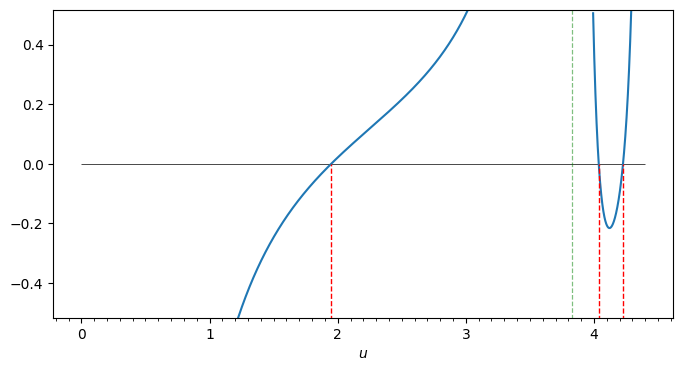

In [27]:
# For EH11 mode

q = 1
eigen_hybrid = gen_eigen_eq(v, ncore, nclad, q, mode='hybrid')

plot_limit = 1
fig, ax = plot_eigen_eq(v, q, eigen_hybrid) # plot eigen value equation

#Draw diverging points 
div_points = get_diverging_points(v, q)
print(f"diverging_points= {div_points}")
ax.vlines(x=div_points, ymin=-plot_limit, ymax=plot_limit, linestyles='dashed', colors='g', alpha=0.5, linewidth=0.9)

# plot roots
init_points = [1.9, 3.9, 4.2]
roots = get_roots(v, q, init_points, eigen_hybrid)
plot_roots(ax, roots, plot_limit)

u_he11 = roots[0] # LP01 mode
u_eh11 = roots[1] # LP21 mode
u_he12 = roots[2] # LP02 mode
print(f"u for HE{q}1: {u_he11:.4f}")
print(f"u for EH{q}1: {u_eh11:.4f}")
print(f"u for HE{q}2: {u_he12:.4f}")

neff_he11 = neff(b(v, u_he11), ncore, nclad)
neff_eh11 = neff(b(v, u_eh11), ncore, nclad)
neff_he12 = neff(b(v, u_he12), ncore, nclad)
print(f"neff of HE11: {neff_he11:.6f} (LP01 mode)")
print(f"neff of EH11: {neff_eh11:.6f} (LP21 mode)")
print(f"neff of HE12: {neff_he12:.6f} (LP02 mode)")

diverging_points= None

u for HE31: 4.0434
neff of HE31: 1.446523 (LP21 mode)


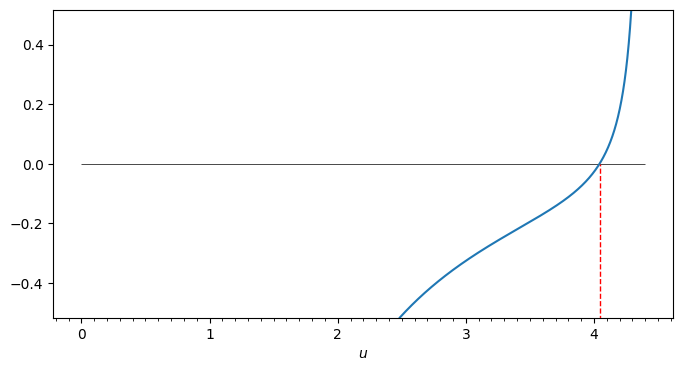

In [28]:
# For HE31 mode

q = 3
eigen_hybrid = gen_eigen_eq(v, ncore, nclad, q, mode='hybrid')

plot_limit = 1

fig, ax = plot_eigen_eq(v, q, eigen_hybrid) # plot eigen value equation

#Draw diverging points 
div_points = get_diverging_points(v, q)
print(f"diverging_points= {div_points}")
ax.vlines(x=div_points, ymin=-plot_limit, ymax=plot_limit, linestyles='dashed', colors='g', alpha=0.5, linewidth=0.9)

# plot roots
init_points = [3.05]
roots = get_roots(v, q, init_points, eigen_hybrid)
u_he31 = roots[0]
print(f"\nu for HE{q}1: {u_he31:.4f}")
plot_roots(ax, roots, plot_limit)


neff_he31= neff(b(v, u_he31), ncore, nclad)
print(f"neff of HE31: {neff_he31:.6f} (LP21 mode)")

### Beatlength between EH11 and HE31

LP21 모드를 구성하는 두 general mode EH11과 HE31 모드의 beatlength 계산

$$
L_B = \frac{\lambda}{\Delta n}
$$

In [29]:
wavelength = 1.55E-6
delta_n = neff_eh11 - neff_he31

print(f"Beatlength btw. EH11 & HE31: {1000*wavelength/delta_n:.3f} mm")

Beatlength btw. EH11 & HE31: 35.228 mm


diverging_points= [2.40482556]

u for TE01: 3.0655
neff of TE01: 1.452360 (LP11 mode)


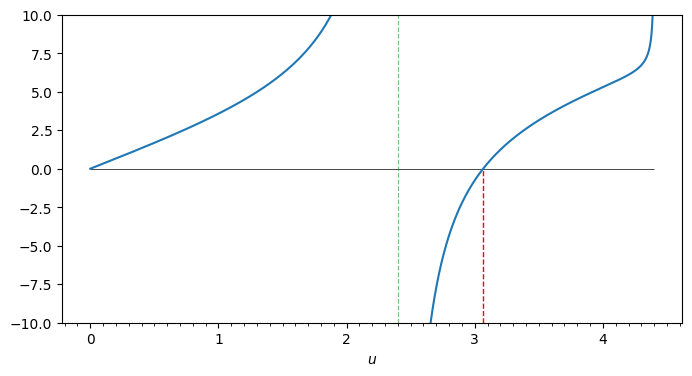

In [30]:
# TE mode

q = 0
plot_limit = 10
eigen_te = gen_eigen_eq(v, ncore, nclad, q, mode='TE')
fig, ax = plot_eigen_eq(v, q, eigen_te, plot_limit)

#Draw diverging points 
div_points = get_diverging_points(v, q)
print(f"diverging_points= {div_points}")
ax.vlines(x=div_points, ymin=-plot_limit, ymax=plot_limit, linestyles='dashed', colors='g', alpha=0.5, linewidth=0.9)

# plot roots
init_points = [3.05]
roots = get_roots(v, q, init_points, eigen_te)
u_te01 = roots[0]
print(f"\nu for TE{q}1: {u_te01:.4f}")
plot_roots(ax, roots, plot_limit)


neff_te01= neff(b(v, u_te01), ncore, nclad)
print(f"neff of TE01: {neff_te01:.6f} (LP11 mode)")

diverging_points= [2.40482556]

u for TM01: 3.0729


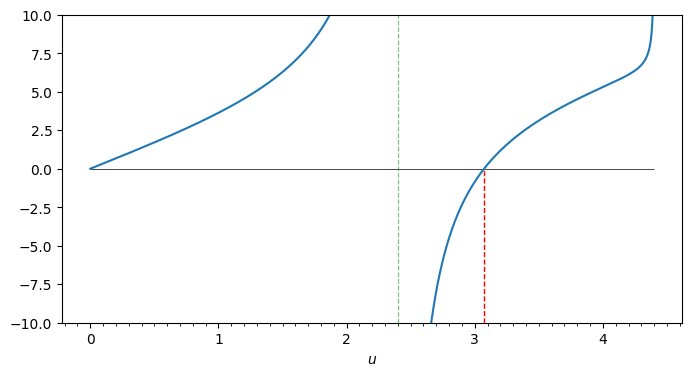

In [31]:
# TM mode

q = 0
plot_limit = 10
eigen_tm = gen_eigen_eq(v, ncore, nclad, q, mode='TM')
fig, ax = plot_eigen_eq(v, q, eigen_tm, plot_limit)

#Draw diverging points 
div_points = get_diverging_points(v, q)
print(f"diverging_points= {div_points}")
ax.vlines(x=div_points, ymin=-plot_limit, ymax=plot_limit, linestyles='dashed', colors='g', alpha=0.5, linewidth=0.9)

# plot roots
init_points = [3.05]
roots = get_roots(v, q, init_points, eigen_tm)
print(f"\nu for TM{q}1: {roots[0]:.4f}")
plot_roots(ax, roots, plot_limit)